In [1]:
import sys
sys.path.insert(0, '/media/allen/mass/deep-learning-works/')
import os.path as osp
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from database.dataset_factory import get_dataset
from manager.manager_factory import get_manager

from config.config_factory import _C as cfg
from config.config_factory import build_output

from tools.logger import setup_logger
logger = setup_logger(".")
from tools.utils import deploy_macro

import cv2
from PIL import Image 

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

from tools.utils import ctdet_decode, ctdet_post_process, _sigmoid

In [2]:
from database.data_factory import get_names as data_names
from database.dataset_factory import get_names as dataset_names
from database.loader_factory import get_names as loader_names
from manager.manager_factory import get_names as manager_names
from engine.engine_factory import get_names as engine_names
print("DATA: ", data_names())
print("DATASET: ", dataset_names())
print("LOADER: ", loader_names())
print("MANAGER: ", manager_names())
print("ENGINE: ", engine_names())

DATA:  ['coco', 'coco_person_kp', 'deepfashion', 'market', 'cuhk01', 'cuhk02', 'cuhk03', 'duke', 'msmt', 'imagenet', 'cifar10']
DATASET:  ['coco_keypoint', 'coco_object', 'reid', 'imagenet', 'cifar10']
LOADER:  ['coco', 'reid', 'imagenet', 'cifar10']
MANAGER:  ['center', 'center_kp', 'imagenet', 'par', 'reid_trick']
ENGINE:  ['center', 'center_kp', 'imagenet', 'par', 'reid_trick']


In [3]:
config_path = '/media/allen/mass/deep-learning-works/config/object.yml'
cfg.merge_from_file(config_path)
cfg.DB.PATH     = '/media/allen/mass/DB/'
cfg.DB.USE_TRAIN = False
cfg.DB.USE_TEST  = True
cfg.MODEL.GPU   = [1]
cfg.MODEL.NORM  = "BN"
cfg.COCO.TARGET = 'original'
cfg.ENGINE      = 'center'
cfg.MANAGER     = 'center'
cfg.DB.DATA     = 'coco'
cfg.DB.DATASET  = 'coco_object'
cfg.DB.LOADER   = 'coco'
cfg.DB.NUM_CLASSES   = 80
cfg.DB.NUM_KEYPOINTS = 0
cfg.EVALUATE         = '../caffe_models/Hourglass-squeeze_coco_focal_regl1_Freeze_Adam_lr_0.0001_plateau_10_COCO_0.2981.pth'
deploy_macro(cfg)

2019-12-20 09:41:36,306 logger INFO: Using GPU: 1


In [4]:
preprocessor = get_dataset(cfg.DB.DATASET).preprocess
MEAN = get_dataset(cfg.DB.DATASET).mean
STD = get_dataset(cfg.DB.DATASET).std

In [5]:
manager = get_manager(cfg.MANAGER)(cfg)
manager.use_multigpu()
model = manager.model
model.eval()

2019-12-20 09:41:37,453 logger INFO: Evaluating model from ../caffe_models/Hourglass-squeeze_coco_focal_regl1_Freeze_Adam_lr_0.0001_plateau_10_COCO_0.2981.pth
2019-12-20 09:41:37,897 logger INFO: Using GPU: 1
2019-12-20 09:41:37,916 logger INFO: Use Single-GPU


Model(
  (backbone): HourglassNet(
    (pre): Sequential(
      (0): convolution(
        (conv): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace)
        )
      )
      (1): residual(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): Sequential(
          (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace)
        )
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skip): Sequential(
          (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
manager.check_size((1,3,512,512))

2019-12-20 09:41:42,680 logger INFO: backbone.pre.0.conv                                         
2019-12-20 09:41:42,681 logger INFO:              input,   1 x   3 x 512 x 512
2019-12-20 09:41:42,682 logger INFO:             output,   1 x 128 x 256 x 256
2019-12-20 09:41:42,684 logger INFO: backbone.pre.0.bn.0                                         
2019-12-20 09:41:42,685 logger INFO:              input,   1 x 128 x 256 x 256
2019-12-20 09:41:42,686 logger INFO:             output,   1 x 128 x 256 x 256
2019-12-20 09:41:42,689 logger INFO: backbone.pre.0.bn.1                                         
2019-12-20 09:41:42,690 logger INFO:              input,   1 x 128 x 256 x 256
2019-12-20 09:41:42,691 logger INFO:             output,   1 x 128 x 256 x 256
2019-12-20 09:41:42,693 logger INFO: backbone.pre.0.bn                                           
2019-12-20 09:41:42,694 logger INFO:              input,   1 x 128 x 256 x 256
2019-12-20 09:41:42,694 logger INFO:             output

2019-12-20 09:41:43,140 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,141 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,142 logger INFO: backbone.hg_mods.0.up1.0.relu                               
2019-12-20 09:41:43,144 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,145 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,145 logger INFO: backbone.hg_mods.0.up1.0                                    
2019-12-20 09:41:43,146 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,146 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,148 logger INFO: backbone.hg_mods.0.up1.1.conv1                              
2019-12-20 09:41:43,149 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,149 logger INFO:             output,   1 x 128 x  64 x  64
2019-12-20 09:41:43,150 logger INFO: backbone.hg_mods.0.up1.1.bn1         

2019-12-20 09:41:43,242 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 09:41:43,244 logger INFO: backbone.hg_mods.0.low2.up1.0.relu                          
2019-12-20 09:41:43,245 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:43,245 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 09:41:43,246 logger INFO: backbone.hg_mods.0.low2.up1.0                               
2019-12-20 09:41:43,247 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:43,248 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 09:41:43,249 logger INFO: backbone.hg_mods.0.low2.up1.1.conv1                         
2019-12-20 09:41:43,250 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:43,251 logger INFO:             output,   1 x 128 x  32 x  32
2019-12-20 09:41:43,252 logger INFO: backbone.hg_mods.0.low2.up1.1.bn1                           
2019-12-20 09:41:43,253 logger INFO:              input

2019-12-20 09:41:43,373 logger INFO: backbone.hg_mods.0.low2.low2.up1.0.relu                     
2019-12-20 09:41:43,373 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:43,375 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:43,376 logger INFO: backbone.hg_mods.0.low2.low2.up1.0                          
2019-12-20 09:41:43,376 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:43,378 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:43,379 logger INFO: backbone.hg_mods.0.low2.low2.up1.1.conv1                    
2019-12-20 09:41:43,379 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:43,380 logger INFO:             output,   1 x 192 x  16 x  16
2019-12-20 09:41:43,381 logger INFO: backbone.hg_mods.0.low2.low2.up1.1.bn1                      
2019-12-20 09:41:43,382 logger INFO:              input,   1 x 192 x  16 x  16
2019-12-20 09:41:43,383 logger INFO:             output

2019-12-20 09:41:43,477 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:43,478 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:43,479 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1.0                     
2019-12-20 09:41:43,479 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:43,481 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:43,482 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1.1.conv1               
2019-12-20 09:41:43,483 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:43,483 logger INFO:             output,   1 x 192 x   8 x   8
2019-12-20 09:41:43,484 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1.1.bn1                 
2019-12-20 09:41:43,485 logger INFO:              input,   1 x 192 x   8 x   8
2019-12-20 09:41:43,486 logger INFO:             output,   1 x 192 x   8 x   8
2019-12-20 09:41:43,488 logger INFO: backbone.hg_mods.0.low2.low2.low2.up1

2019-12-20 09:41:43,588 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 09:41:43,589 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.0                    
2019-12-20 09:41:43,591 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:43,591 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 09:41:43,594 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.1.conv1              
2019-12-20 09:41:43,595 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:43,596 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 09:41:43,597 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.1.bn1                
2019-12-20 09:41:43,598 logger INFO:              input,   1 x 256 x   4 x   4
2019-12-20 09:41:43,599 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 09:41:43,601 logger INFO: backbone.hg_mods.0.low2.low2.low2.low2.1.conv_1x1           
2019-12-20 09:41:43,602 logger INFO:              input

2019-12-20 09:41:43,709 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.conv_1x1           
2019-12-20 09:41:43,711 logger INFO:              input,   1 x 192 x   4 x   4
2019-12-20 09:41:43,713 logger INFO:             output,   1 x 192 x   4 x   4
2019-12-20 09:41:43,715 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.conv_3x3           
2019-12-20 09:41:43,717 logger INFO:              input,   1 x 192 x   4 x   4
2019-12-20 09:41:43,718 logger INFO:             output,   1 x 192 x   4 x   4
2019-12-20 09:41:43,720 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.bn2.0              
2019-12-20 09:41:43,721 logger INFO:              input,   1 x 384 x   4 x   4
2019-12-20 09:41:43,722 logger INFO:             output,   1 x 384 x   4 x   4
2019-12-20 09:41:43,723 logger INFO: backbone.hg_mods.0.low2.low2.low2.low3.1.bn2.1              
2019-12-20 09:41:43,724 logger INFO:              input,   1 x 384 x   4 x   4
2019-12-20 09:41:43,728 logger INFO:             output

2019-12-20 09:41:43,855 logger INFO:             output,   1 x 192 x  16 x  16
2019-12-20 09:41:43,856 logger INFO: backbone.hg_mods.0.low2.low3.0.bn2                          
2019-12-20 09:41:43,856 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:43,857 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:43,858 logger INFO: backbone.hg_mods.0.low2.low3.0.relu                         
2019-12-20 09:41:43,858 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:43,859 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:43,861 logger INFO: backbone.hg_mods.0.low2.low3.0                              
2019-12-20 09:41:43,861 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:43,862 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:43,867 logger INFO: backbone.hg_mods.0.low2.low3.1.conv1                        
2019-12-20 09:41:43,868 logger INFO:              input

2019-12-20 09:41:43,972 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,972 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,973 logger INFO: backbone.hg_mods.0                                          
2019-12-20 09:41:43,973 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,974 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,974 logger INFO: backbone.cnvs.0.conv                                        
2019-12-20 09:41:43,975 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,975 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,977 logger INFO: backbone.cnvs.0.bn.0                                        
2019-12-20 09:41:43,977 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:43,978 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:43,979 logger INFO: backbone.cnvs.0.bn.1                 

2019-12-20 09:41:44,137 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:44,139 logger INFO: backbone.inters.0.conv2                                     
2019-12-20 09:41:44,140 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:44,140 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:44,142 logger INFO: backbone.inters.0.bn2                                       
2019-12-20 09:41:44,142 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:44,143 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:44,144 logger INFO: backbone.inters.0.skip                                      
2019-12-20 09:41:44,145 logger INFO:              input,   1 x 256 x  64 x  64
2019-12-20 09:41:44,146 logger INFO:             output,   1 x 256 x  64 x  64
2019-12-20 09:41:44,150 logger INFO: backbone.inters.0.relu                                      
2019-12-20 09:41:44,151 logger INFO:              input

2019-12-20 09:41:44,250 logger INFO: backbone.hg_mods.1.low1.1.conv_3x3                          
2019-12-20 09:41:44,251 logger INFO:              input,   1 x 128 x  32 x  32
2019-12-20 09:41:44,251 logger INFO:             output,   1 x 128 x  32 x  32
2019-12-20 09:41:44,254 logger INFO: backbone.hg_mods.1.low1.1.bn2                               
2019-12-20 09:41:44,255 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:44,256 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 09:41:44,257 logger INFO: backbone.hg_mods.1.low1.1.relu                              
2019-12-20 09:41:44,258 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:44,260 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 09:41:44,261 logger INFO: backbone.hg_mods.1.low1.1                                   
2019-12-20 09:41:44,262 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:44,264 logger INFO:             output

2019-12-20 09:41:44,369 logger INFO:              input,   1 x 192 x  16 x  16
2019-12-20 09:41:44,370 logger INFO:             output,   1 x 192 x  16 x  16
2019-12-20 09:41:44,372 logger INFO: backbone.hg_mods.1.low2.low1.1.bn2                          
2019-12-20 09:41:44,373 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:44,374 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:44,376 logger INFO: backbone.hg_mods.1.low2.low1.1.relu                         
2019-12-20 09:41:44,380 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:44,381 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:44,382 logger INFO: backbone.hg_mods.1.low2.low1.1                              
2019-12-20 09:41:44,382 logger INFO:              input,   1 x 384 x  16 x  16
2019-12-20 09:41:44,383 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:44,385 logger INFO: backbone.hg_mods.1.low2.low1         

2019-12-20 09:41:44,485 logger INFO:             output,   1 x 192 x   8 x   8
2019-12-20 09:41:44,486 logger INFO: backbone.hg_mods.1.low2.low2.low1.1.bn2                     
2019-12-20 09:41:44,487 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,487 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:44,489 logger INFO: backbone.hg_mods.1.low2.low2.low1.1.relu                    
2019-12-20 09:41:44,489 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,489 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:44,490 logger INFO: backbone.hg_mods.1.low2.low2.low1.1                         
2019-12-20 09:41:44,490 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,491 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:44,492 logger INFO: backbone.hg_mods.1.low2.low2.low1                           
2019-12-20 09:41:44,493 logger INFO:              input

2019-12-20 09:41:44,567 logger INFO: backbone.hg_mods.1.low2.low2.low2.low1.1.bn2                
2019-12-20 09:41:44,568 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:44,569 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 09:41:44,570 logger INFO: backbone.hg_mods.1.low2.low2.low2.low1.1.relu               
2019-12-20 09:41:44,571 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:44,572 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 09:41:44,572 logger INFO: backbone.hg_mods.1.low2.low2.low2.low1.1                    
2019-12-20 09:41:44,573 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:44,575 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 09:41:44,575 logger INFO: backbone.hg_mods.1.low2.low2.low2.low1                      
2019-12-20 09:41:44,575 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,576 logger INFO:             output

2019-12-20 09:41:44,645 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:44,645 logger INFO:             output,   1 x 512 x   4 x   4
2019-12-20 09:41:44,647 logger INFO: backbone.hg_mods.1.low2.low2.low2.low3.0.conv1              
2019-12-20 09:41:44,648 logger INFO:              input,   1 x 512 x   4 x   4
2019-12-20 09:41:44,648 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 09:41:44,649 logger INFO: backbone.hg_mods.1.low2.low2.low2.low3.0.bn1                
2019-12-20 09:41:44,650 logger INFO:              input,   1 x 256 x   4 x   4
2019-12-20 09:41:44,651 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 09:41:44,653 logger INFO: backbone.hg_mods.1.low2.low2.low2.low3.0.conv_1x1           
2019-12-20 09:41:44,654 logger INFO:              input,   1 x 256 x   4 x   4
2019-12-20 09:41:44,655 logger INFO:             output,   1 x 256 x   4 x   4
2019-12-20 09:41:44,656 logger INFO: backbone.hg_mods.1.low2.low2.low2.low

2019-12-20 09:41:44,727 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,728 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:44,729 logger INFO: backbone.hg_mods.1.low2.low2.low3.1                         
2019-12-20 09:41:44,729 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,730 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:44,731 logger INFO: backbone.hg_mods.1.low2.low2.low3                           
2019-12-20 09:41:44,731 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,732 logger INFO:             output,   1 x 384 x   8 x   8
2019-12-20 09:41:44,733 logger INFO: backbone.hg_mods.1.low2.low2.up2                            
2019-12-20 09:41:44,734 logger INFO:              input,   1 x 384 x   8 x   8
2019-12-20 09:41:44,734 logger INFO:             output,   1 x 384 x  16 x  16
2019-12-20 09:41:44,735 logger INFO: backbone.hg_mods.1.low2.low2.merg    

2019-12-20 09:41:44,807 logger INFO:             output,   1 x 256 x  32 x  32
2019-12-20 09:41:44,810 logger INFO: backbone.hg_mods.1.low3.1.conv1                             
2019-12-20 09:41:44,810 logger INFO:              input,   1 x 256 x  32 x  32
2019-12-20 09:41:44,811 logger INFO:             output,   1 x 128 x  32 x  32
2019-12-20 09:41:44,813 logger INFO: backbone.hg_mods.1.low3.1.bn1                               
2019-12-20 09:41:44,813 logger INFO:              input,   1 x 128 x  32 x  32
2019-12-20 09:41:44,814 logger INFO:             output,   1 x 128 x  32 x  32
2019-12-20 09:41:44,815 logger INFO: backbone.hg_mods.1.low3.1.conv_1x1                          
2019-12-20 09:41:44,815 logger INFO:              input,   1 x 128 x  32 x  32
2019-12-20 09:41:44,816 logger INFO:             output,   1 x 128 x  32 x  32
2019-12-20 09:41:44,818 logger INFO: backbone.hg_mods.1.low3.1.conv_3x3                          
2019-12-20 09:41:44,819 logger INFO:              input

In [38]:
path = "/media/allen/mass/office/office_valid/CAM1-2019-11-12_11-28-14_9900.jpg"
img = cv2.imread(path)
batch = preprocessor(img, [1.0], (img.shape[1], img.shape[0]))

In [39]:
inputs = torch.Tensor(batch['inputs']).cuda()
with torch.no_grad():
    out = model(inputs)
feat = out[-1]
feat['hm'] = _sigmoid(feat['hm'])


In [40]:
dets = ctdet_decode(feat['hm'], feat['wh'], reg=feat['reg'], K=100)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[1])
dets_out = ctdet_post_process(dets.copy(), batch['c'], batch['s'], 
                              feat['hm'].shape[2], feat['hm'].shape[3], feat['hm'].shape[1])

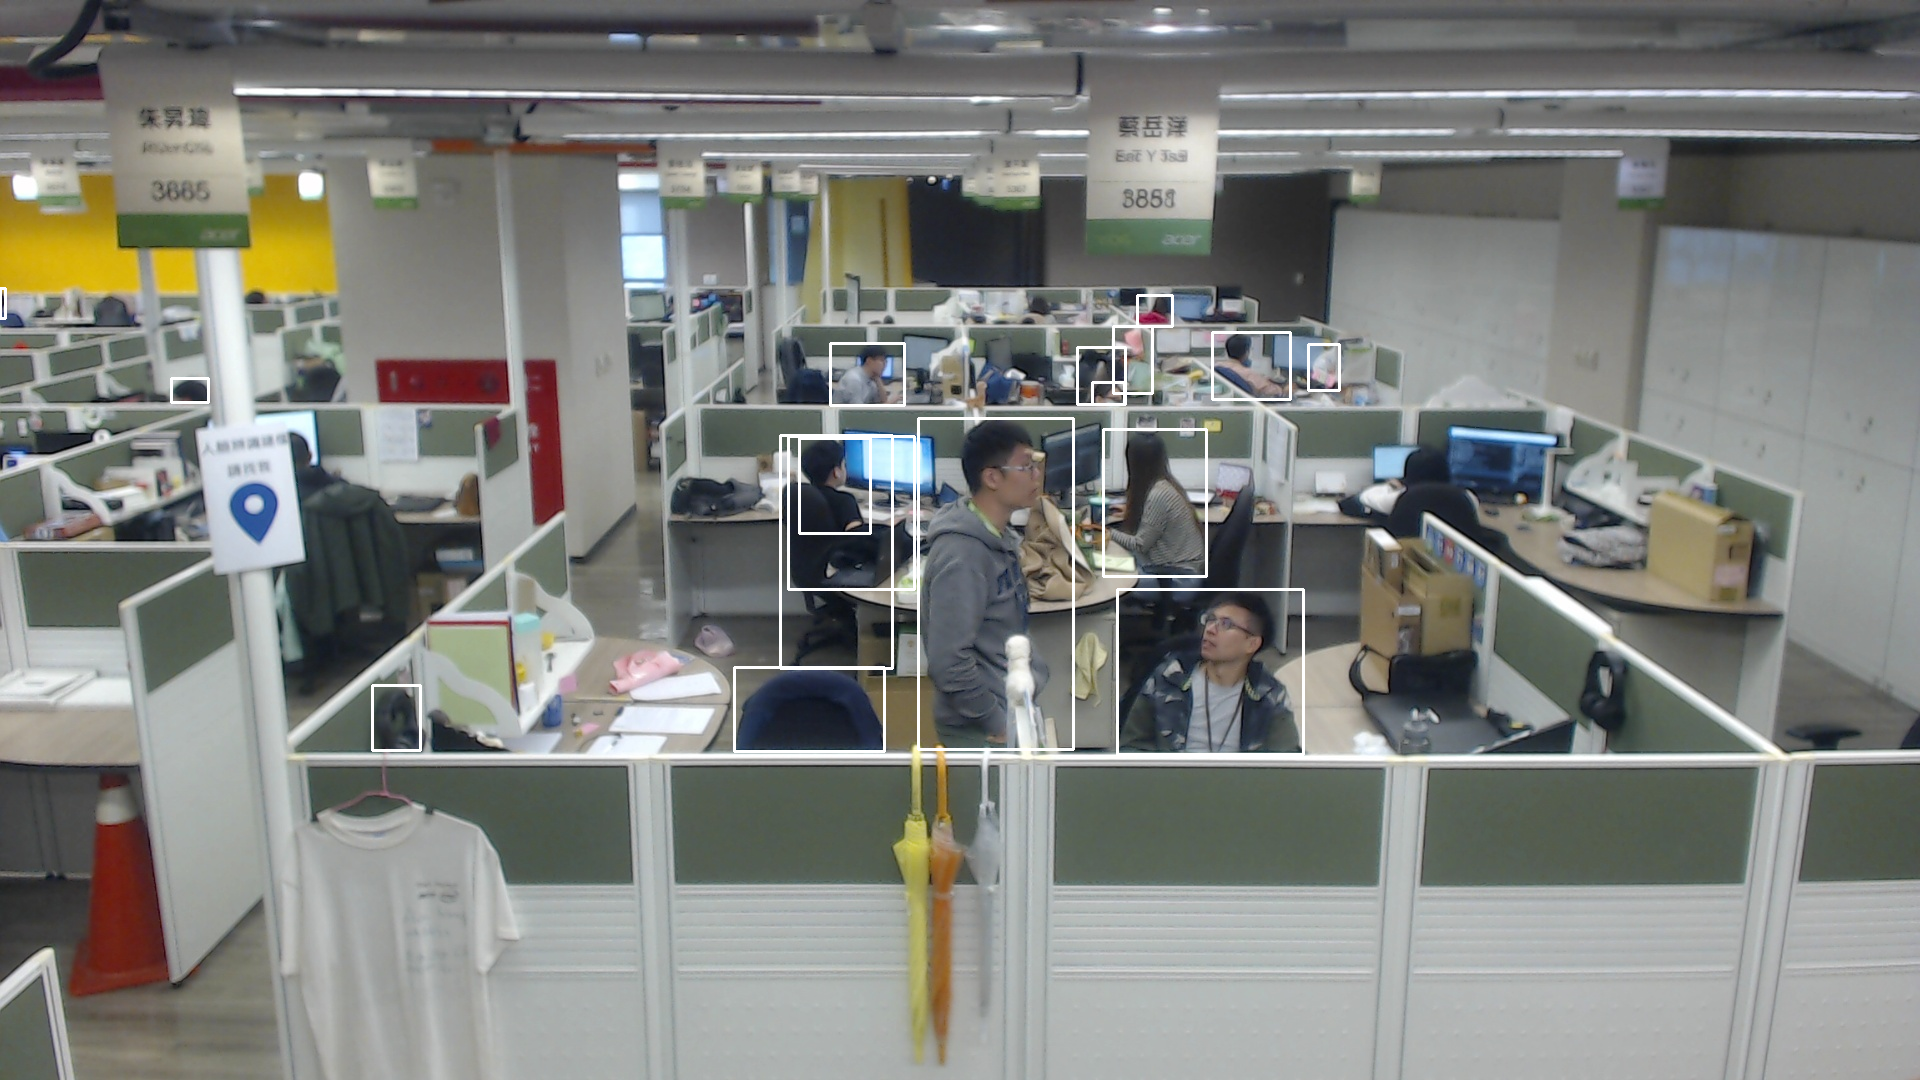

In [55]:
# np_img = batch['inputs'].copy()
# np_img = np_img[0].transpose(1,2,0)
# np_img = (np_img * STD + MEAN)*255
# np_img = np_img.astype(np.uint8)
# h, w = np_img.shape[:2]
# np_img = cv2.resize(np_img, (w,h))
# c = batch['c'][0].astype(int)
# cv2.circle(np_img, (int(c[0]), int(c[1])), 3, (0,0,0), 3)
np_img = cv2.imread(path)
for cls in dets_out[0].keys():
    if cls == 1:
        for bbox in dets_out[0][cls]:
            x1, y1, x2, y2, score = bbox
            if score > 0.2:
                if x1 < 0:
                    x1 = 0
                if y1 < 0:
                    y1 = 0

                cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,255), 2)
            
# for bbox in dets[dets[:,:,4]>0.3]:
#     x1, y1, x2, y2 = bbox[:4]
#     w, h = x2-x1, y2-y1
#     w *= 8
#     h *= 8
#     x1 *= 8
#     y1 *= 8
#     x2 = x1 + w
#     y2 = y1 + h
#     cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,255), 2)
to_pil(np_img)